# ISCAS Paper Work
See `ifat.py` for synaptic connetvitiy plots

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [3]:
def calc_weight(M, alpha, mu, sigma):
    alpha = alpha/fF
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * np.around(output/(5.0))
    output[output==0.] = nan
    return output

In [4]:
MODE = 'adaptive'
PARASITICS = True

In [5]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [6]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [7]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [8]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [ ]:
start_scope()

blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_exc.Vt = Vt_r
blair_exc.Vm = Vm_r

blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh.Vt = Vt_r
blair_inh.Vm = Vm_r

In [ ]:
exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[3]
exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

In [ ]:
PoisIn = PoissonGroup(M,rates=0*kHz)
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = W_vals[2] + W_vals[0]# + W_vals[0]

In [ ]:
i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
inrate = PopulationRateMonitor(PoisIn)
erate00 = PopulationRateMonitor(blair_exc[:1])
erate15 = PopulationRateMonitor(blair_exc[15:16])
erate31 = PopulationRateMonitor(blair_exc[31:32])
erate47 = PopulationRateMonitor(blair_exc[47:48])
ratecheck = StateMonitor(PoisIn, 'rates',record=True)
#irate = PopulationRateMonitor(blair_inh[:1])

In [ ]:
store()
poissonRates = arange(2.0,4.0,0.1)*kHz

In [ ]:
#rateOuts = zeros((4,20))
eRates00 = []; eRates00b = []; eRates00c = []
eRates15 = []; eRates15b = []; eRates15c = []
eRates31 = []; eRates31b = []; eRates31c = []
eRates47 = []; eRates47b = []; eRates47c = []

In [ ]:
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
for thing in range(3):
    for poissonRate in poissonRates:
        restore()
        PoisIn.rates = poissonRate
        print(poissonRate)
        run(8*second,report='text')
        if thing == 0:
            eRates00.append(erate00.smooth_rate(width=100*ms))
            eRates15.append(erate15.smooth_rate(width=100*ms))
            eRates31.append(erate31.smooth_rate(width=100*ms))
            eRates47.append(erate47.smooth_rate(width=100*ms))
        elif thing == 1:
            eRates00b.append(erate00.smooth_rate(width=100*ms))
            eRates15b.append(erate15.smooth_rate(width=100*ms))
            eRates31b.append(erate31.smooth_rate(width=100*ms))
            eRates47b.append(erate47.smooth_rate(width=100*ms))
        else:
            eRates00c.append(erate00.smooth_rate(width=100*ms))
            eRates15c.append(erate15.smooth_rate(width=100*ms))
            eRates31c.append(erate31.smooth_rate(width=100*ms))
            eRates47c.append(erate47.smooth_rate(width=100*ms))

In [ ]:
figure(figsize=(8,6))
plot(e_spmon.t/ms, e_spmon.i,'.'); xlim([5000,5250])
xlabel('Time (ms)')
ylabel('Neuron index')

In [ ]:
rateWidth = 1000 * ms
plot(erate00.t/second, erate00.smooth_rate(width=rateWidth)/Hz,
     erate15.t/second, erate15.smooth_rate(width=rateWidth)/Hz,
     erate31.t/second, erate31.smooth_rate(width=rateWidth)/Hz,
     erate47.t/second, erate47.smooth_rate(width=rateWidth)/Hz)
xlim([2,6])

In [ ]:
idx = 32
plot(e_vmon.t/ms-5000, e_vmon.Vm[idx]); xlim([0,250])
scatter(e_spmon.t[e_spmon.i==idx]/ms-5000,3.65*ones(len(e_spmon.t[e_spmon.i==idx])),color='r')
xlabel('Time (ms)')
ylabel('Membrane Voltage (V)')

In [ ]:
smooth_width = 1000*ms

sig_shape = shape(eRates00)
avgRate = zeros(sig_shape)
avgRateB = zeros(sig_shape)
avgRateC = zeros(sig_shape)

for i in range(sig_shape[0]):
    avgRate[i,:]  = eRates00[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates15[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates31[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates47[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] = avgRate[i,:]/4
    avgRateB[i,:]  = eRates00b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates15b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates31b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates47b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] = avgRateB[i,:]/4
    avgRateC[i,:]  = eRates00c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates15c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates31c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates47c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] = avgRateC[i,:]/4

In [ ]:
plot(erate00.t/second, avgRateB[0,:]/Hz,
     erate00.t/second, avgRateB[1,:]/Hz,
     erate00.t/second, avgRateB[2,:]/Hz,
     erate00.t/second, avgRateB[3,:]/Hz)

In [ ]:
for i in range(sig_shape[0]):    
    plot(erate00.t/second, avgRate[i,:]/Hz)
xlim([1.5,6.5])

In [ ]:
cut_start = 15000; cut_stop = 50000
meanRates = np.mean(avgRate[:,cut_start:cut_stop], axis=1)
stdRates  = np.std(avgRate[:,cut_start:cut_stop], axis=1)
meanRatesB = np.mean(avgRateB[:,cut_start:cut_stop], axis=1)
stdRatesB  = np.std(avgRateB[:,cut_start:cut_stop], axis=1)
meanRatesC = np.mean(avgRateC[:,cut_start:cut_stop], axis=1)
stdRatesC  = np.std(avgRateC[:,cut_start:cut_stop], axis=1)

In [ ]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRates, yerr=stdRates)
ax.errorbar(poissonRates/1000, meanRatesB, yerr=stdRatesB)
ax.errorbar(poissonRates/1000, meanRatesC, yerr=stdRatesC)

In [ ]:
totAvgRate = (avgRate + avgRateB + avgRateC)/3.0
meanRatesTotal = np.mean(totAvgRate[:,cut_start:cut_stop], axis=1)
stdRatesTotal = np.std(totAvgRate[:,cut_start:cut_stop], axis=1)

In [ ]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRatesTotal, yerr=stdRatesTotal, color='C0', LineWidth=2.5, ecolor='C1')
xlabel('Mean Input Rate (kHz)')
ylabel('Angular Frequency (Hz)')
grid()

## Making Everything Easy for Bayo

In [10]:
start_scope()

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
W1_e2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_e2i[ii,jj]):
            G1_e2i.connect(i=ii,j=jj)
G1_e2i.Em = Em_vals[3]
G1_e2i.W = W1_e2i[~isnan(W1_e2i)].flatten()*fF

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
W1_i2e = calc_weight(M,alpha,mu2,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2e[ii,jj]):
            G1_i2e.connect(i=ii,j=jj)
G1_i2e.Em = Em_vals[0]
G1_i2e.W = W1_i2e[~isnan(W1_i2e)].flatten()*fF

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
W1_i2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2i[ii,jj]):
            G1_i2i.connect(i=ii,j=jj)
G1_i2i.Em = Em_vals[0]
G1_i2i.W = W1_i2i[~isnan(W1_i2i)].flatten()*fF

P1_rates = '(3)*kHz'
P1 = PoissonGroup(M,rates=P1_rates)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[3]
P1_syn.W = W_vals[2] + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
G1e_v  = StateMonitor(G1_exc, 'Vm', record=True)
P1_rate = StateMonitor(P1, 'rates',record=True)

In [11]:
run(10*second, report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

Starting simulation at t=0. s for a duration of 10. s
10.0 (100%) simulated in 7s


(1000, 1020)

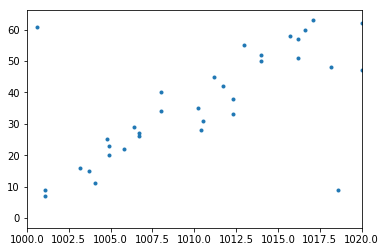

In [17]:
plot(G1e_sp.t/ms,G1e_sp.i,'.')
xlim([1000,1020])

(1000, 1010)

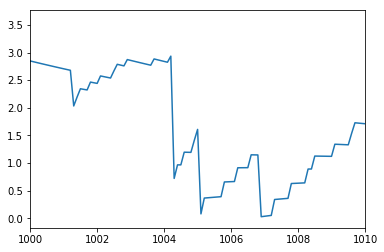

In [16]:
plot(G1e_v.t/ms, G1e_v.Vm[0])
xlim([1000,1010])

In [33]:
group1 = {'weights': W1_e2i, 'Em': 3, 'stype': 0, 'ttype': 1}
group2 = {'weights': W1_i2e, 'Em': 0, 'stype': 1, 'ttype': 0}
group3 = {'weights': W1_i2i, 'Em': 0, 'stype': 1, 'ttype': 1}

In [307]:
def print_exc_syn(group):
    M = shape(group['weights'])
    for i in range(10):
        print('{}:'.format(i), end=' ')
        for j in range(M[1]):
            if ~isnan(group['weights'][i,j]):
                print(j, (group['weights'][i,j]/5).astype(int), group['Em'])#, end=' ')
        print()
        print()

In [23]:
def make_event(index, addr_x, wm, em_sel, wt=0, chip_sel=1, thr_switch=0, debug=0):
    if(debug):
        print("\tMaking event..\n");

    wm_pos = 0;
    wt_pos = 5;
    row_pos = 10;
    col_pos = 16;
    em_sel_pos = 22;
    chip_sel_pos = 24;
    col_sel_pos = 28;
    addr_x_pos = 29;
    thr_switch_pos = 30;
    num_rows = 34;
    num_cols = 30;
    col_sel = 1;

    row = int(index/num_cols);
    col = int(index%num_rows);
    row_i = (row<<row_pos) & (0b11111<<row_pos);
    col_i = (col<<col_pos) & (0b11111<<col_pos);
    addrx_i = (addr_x<<addr_x_pos) & (0b11111<<addr_x_pos);
    wm_i = (wm<<wm_pos) & (0b11111<<wm_pos);
    wt_i = (wt<<wt_pos) & (0b11111<<wt_pos);
    em_i = (em_sel<<em_sel_pos) & (0b11111<<em_sel_pos);
    cs_i = (chip_sel<<chip_sel_pos) & (0b11111<<chip_sel_pos);
    col_sel_i = (col_sel<<col_sel_pos) & (0b11111<<col_sel_pos);
    thr_sw_i = (thr_switch<<thr_switch_pos) & (0b11111<<thr_switch_pos);

    out_event = row_i | col_i | addrx_i | wm_i | wt_i | em_i | cs_i | col_sel_i | thr_sw_i;
    out_event = out_event & 0xffffffff
    
    if(debug):
        print("\t\tout event:",end=' ')
        print(format(out_event, '032b'))

    return out_event;

In [305]:
def print_exc_syn2(group):
    M = shape(group['weights'])
    for i in range(M[0]):
        print('{}:'.format(i+30*34*group['stype']), end='')
        for j in range(M[1]):
            if ~isnan(group['weights'][i,j]):
                print(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em']), end=' ')
        print()

In [43]:
def write_exc_syn(group, file):
    M = shape(group['weights'])
    with open(file,'w') as f:
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*group['stype']))
            for j in range(M[1]):
                if ~isnan(group['weights'][i,j]):
                    f.write(str(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

In [44]:
write_exc_syn(group1,'check_exc.txt')

In [290]:
def print_inh_syn2(i2e,i2i):
    M = shape(i2e['weights'])
    for i in range(M[0]):
        print('{}:'.format(i+30*34*i2e['stype']), end='')
        for j in range(M[1]):
            if ~isnan(i2e['weights'][i,j]):
                print(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em']), end=' ')
            if ~isnan(i2i['weights'][i,j]):
                print(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em']), end=' ')
        print()

In [47]:
def write_inh_syn(i2e, i2i, file):
    M = shape(i2e['weights'])
    with open(file,'w') as f:
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*i2e['stype']))
            for j in range(M[1]):
                if ~isnan(i2e['weights'][i,j]):
                    f.write(str(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em'])) + ' ')
                if ~isnan(i2i['weights'][i,j]):
                    f.write(str(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

In [48]:
write_inh_syn(group2,group3,'check_inh.txt')

In [19]:
def poissonSpikeGen(rate=3*kHz, dt=100*us, t=1*second, num_neur=1):
    bins = int(t/dt)
    print(bins)
    output = rand(num_neur, bins) < rate*dt
    time = arange(0,t-dt,dt)
    return time, output

In [25]:
time, out = poissonSpikeGen(rate=3*kHz, dt=100*us, t=2*second, num_neur=64)

20000


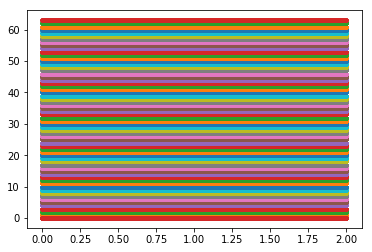

In [26]:
for i in range(M):
    plot(time,out[i]*i,'.'); 

In [53]:
def write_poisson_stim(time, spikes, file):
    with open(file, 'w') as f:
        for i, t in enumerate(time):
            f.write('{}:'.format(round(t/us)))
            for j in range(shape(spikes)[0]):
                if spikes[j,i]:
                    # this is currently specific, we can generalize it
                    f.write('{} '.format(make_event(j, 0, 5, 3)))
            if i<len(time)-1:
                f.write('\n')

In [54]:
write_poisson_stim(time,out,'vco_stim.txt')